#  Factors Influencing Steam Game Success: A Predictive Analysis of Positive Ratings  

In this project, we aim to analyze what factors may have contributed to a positive rate of the game on Steam using a comprehensive dataset of information on games. We will investigate the relationship between several game variances (price, developer, game type..etc) and the positive rate percentage. By using the technique we learned from this course, we wish to find the key factors that contribute the most to game success and develop a model to predict the game’s potential positive rate depending on its features.

## Loading and Visualizing the Data

Download the Steam games dataset from [Kaggle]('https://www.kaggle.com/datasets/nikdavis/steam-store-games/data?select=steam.csv').

We first get a glimpse of the data within each spreadsheet. This helps to get a feel for what the datasets look like before further analysis.

The dataset contains various features such as appid, genre, developer, release date, price, user ratings, etc.


In [2]:
import pandas as pd
steam_requirements_data = pd.read_csv('/content/steam_requirements_data.csv', encoding='latin-1')
steamspy_tag_data = pd.read_csv('/content/steamspy_tag_data.csv')
steam_data = pd.read_csv('/content/steam.csv')

In [3]:
datasets_overview = {
    "steam_requirements_data": steam_requirements_data.head(),
    "steamspy_tag_data": steamspy_tag_data.head(),
    "steam_data": steam_data.head()
}
datasets_overview

{'steam_requirements_data':    appid                                    pc_requirements  \
 0     10  {'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...   
 1     20  {'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...   
 2     30  {'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...   
 3     40  {'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...   
 4     50  {'minimum': '\r\n\t\t\t<p><strong>Minimum:</st...   
 
                                     mac_requirements  \
 0  {'minimum': 'Minimum: OS X  Snow Leopard 10.6....   
 1  {'minimum': 'Minimum: OS X  Snow Leopard 10.6....   
 2  {'minimum': 'Minimum: OS X  Snow Leopard 10.6....   
 3  {'minimum': 'Minimum: OS X  Snow Leopard 10.6....   
 4  {'minimum': 'Minimum: OS X  Snow Leopard 10.6....   
 
                                   linux_requirements  \
 0  {'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...   
 1  {'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...   
 2  {'minimum': 'Minimum: Linux Ubuntu 12.04, Dual...   
 3  {'minimum':

In [4]:
column_names = {
    "steam_data": steam_data.columns.tolist(),
    "steamspy_tag_data": steamspy_tag_data.columns.tolist(),
    "steam_requirements_data": steam_requirements_data.columns.tolist(),
}
column_names

{'steam_data': ['appid',
  'name',
  'release_date',
  'english',
  'developer',
  'publisher',
  'platforms',
  'required_age',
  'categories',
  'genres',
  'steamspy_tags',
  'achievements',
  'positive_ratings',
  'negative_ratings',
  'average_playtime',
  'median_playtime',
  'owners',
  'price'],
 'steamspy_tag_data': ['appid',
  '1980s',
  '1990s',
  '2.5d',
  '2d',
  '2d_fighter',
  '360_video',
  '3d',
  '3d_platformer',
  '3d_vision',
  '4_player_local',
  '4x',
  '6dof',
  'atv',
  'abstract',
  'action',
  'action_rpg',
  'action_adventure',
  'addictive',
  'adventure',
  'agriculture',
  'aliens',
  'alternate_history',
  'america',
  'animation_&_modeling',
  'anime',
  'arcade',
  'arena_shooter',
  'artificial_intelligence',
  'assassin',
  'asynchronous_multiplayer',
  'atmospheric',
  'audio_production',
  'bmx',
  'base_building',
  'baseball',
  'based_on_a_novel',
  'basketball',
  'batman',
  'battle_royale',
  'beat_em_up',
  'beautiful',
  'benchmark',
  'bike

In [7]:
merged_df = pd.merge(
    steam_data,
    steamspy_tag_data,
    on='appid',
    how='left',
    suffixes=('', '_tags')
)

final_merged_df = pd.merge(
    merged_df,
    steam_requirements_data,
    on='appid',
    how='left',
    suffixes=('', '_req')
)

# Check for any missing values after merge
missing_values = final_merged_df.isnull().sum()
print("\nMissing values in merged dataset:")
print(missing_values[missing_values > 0])

# Save the merged dataset
final_merged_df.to_csv('merged_steam_data.csv', index=False)
print("\nMerged dataset has been saved as 'merged_steam_data.csv'")

print(f"\nFinal merged dataset rows: {len(final_merged_df)}")


Missing values in merged dataset:
developer                 1
publisher                14
pc_requirements          13
mac_requirements         13
linux_requirements       13
minimum                  18
recommended           13057
dtype: int64

Merged dataset has been saved as 'merged_steam_data.csv'

Final merged dataset rows: 27075


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from datetime import datetime

# Load the merged dataset
df = pd.read_csv('merged_steam_data.csv', encoding='latin-1')

# Define game types (now as numerical features)
game_types = ['1980s', '1990s', '2.5d', '2d', '2d_fighter', '360_video', '3d', '3d_platformer',
              '3d_vision', '4_player_local', '4x', '6dof', 'atv', 'abstract', 'action', 'action_rpg',
              'action_adventure', 'addictive', 'adventure', 'agriculture', 'aliens', 'alternate_history',
              'america', 'animation_&_modeling', 'anime', 'arcade', 'arena_shooter', 'artificial_intelligence',
              'assassin', 'asynchronous_multiplayer', 'atmospheric', 'audio_production', 'bmx', 'base_building',
              'baseball', 'based_on_a_novel', 'basketball', 'batman', 'battle_royale', 'beat_em_up',
              'beautiful', 'benchmark', 'bikes', 'blood', 'board_game', 'bowling', 'building', 'bullet_hell',
              'bullet_time', 'crpg', 'capitalism', 'card_game', 'cartoon', 'cartoony', 'casual', 'cats',
              'character_action_game', 'character_customization', 'chess', 'choices_matter',
              'choose_your_own_adventure', 'cinematic', 'city_builder', 'class_based', 'classic', 'clicker',
              'co_op', 'co_op_campaign', 'cold_war', 'colorful', 'comedy', 'comic_book', 'competitive',
              'conspiracy', 'controller', 'conversation', 'crafting', 'crime', 'crowdfunded', 'cult_classic',
              'cute', 'cyberpunk', 'cycling', 'dark', 'dark_comedy', 'dark_fantasy', 'dark_humor',
              'dating_sim', 'demons', 'design_&_illustration', 'destruction', 'detective', 'difficult',
              'dinosaurs', 'diplomacy', 'documentary', 'dog', 'dragons', 'drama', 'driving',
              'dungeon_crawler', 'dungeons_&_dragons', 'dynamic_narration', 'dystopian_', 'early_access',
              'economy', 'education', 'emotional', 'epic', 'episodic', 'experience', 'experimental',
              'exploration', 'fmv', 'fps', 'faith', 'family_friendly', 'fantasy', 'fast_paced',
              'feature_film', 'female_protagonist', 'fighting', 'first_person', 'fishing', 'flight',
              'football', 'foreign', 'free_to_play', 'funny', 'futuristic', 'gambling', 'game_development',
              'gamemaker', 'games_workshop', 'gaming', 'god_game', 'golf', 'gore', 'gothic',
              'grand_strategy', 'great_soundtrack', 'grid_based_movement', 'gun_customization',
              'hack_and_slash', 'hacking', 'hand_drawn', 'hardware', 'heist', 'hex_grid', 'hidden_object',
              'historical', 'hockey', 'horror', 'horses', 'hunting', 'illuminati', 'indie',
              'intentionally_awkward_controls', 'interactive_fiction', 'inventory_management',
              'investigation', 'isometric', 'jrpg', 'jet', 'kickstarter', 'lego', 'lara_croft',
              'lemmings', 'level_editor', 'linear', 'local_co_op', 'local_multiplayer', 'logic', 'loot',
              'lore_rich', 'lovecraftian', 'mmorpg', 'moba', 'magic', 'management', 'mars', 'martial_arts',
              'massively_multiplayer', 'masterpiece', 'match_3', 'mature', 'mechs', 'medieval', 'memes',
              'metroidvania', 'military', 'mini_golf', 'minigames', 'minimalist', 'mining', 'mod',
              'moddable', 'modern', 'motocross', 'motorbike', 'mouse_only', 'movie', 'multiplayer',
              'multiple_endings', 'music', 'music_based_procedural_generation', 'mystery', 'mystery_dungeon',
              'mythology', 'nsfw', 'narration', 'naval', 'ninja', 'noir', 'nonlinear', 'nudity',
              'offroad', 'old_school', 'on_rails_shooter', 'online_co_op', 'open_world', 'otome',
              'parkour', 'parody_', 'party_based_rpg', 'perma_death', 'philisophical', 'photo_editing',
              'physics', 'pinball', 'pirates', 'pixel_graphics', 'platformer', 'point_&_click',
              'political', 'politics', 'pool', 'post_apocalyptic', 'procedural_generation', 'programming',
              'psychedelic', 'psychological', 'psychological_horror', 'puzzle', 'puzzle_platformer',
              'pve', 'pvp', 'quick_time_events', 'rpg', 'rpgmaker', 'rts', 'racing', 'real_time_tactics',
              'real_time', 'real_time_with_pause', 'realistic', 'relaxing', 'remake', 'replay_value',
              'resource_management', 'retro', 'rhythm', 'robots', 'rogue_like', 'rogue_lite', 'romance',
              'rome', 'runner', 'sailing', 'sandbox', 'satire', 'sci_fi', 'science', 'score_attack',
              'sequel', 'sexual_content', 'shoot_em_up', 'shooter', 'short', 'side_scroller',
              'silent_protagonist', 'simulation', 'singleplayer', 'skateboarding', 'skating', 'skiing',
              'sniper', 'snow', 'snowboarding', 'soccer', 'software', 'software_training', 'sokoban',
              'souls_like', 'soundtrack', 'space', 'space_sim', 'spectacle_fighter', 'spelling',
              'split_screen', 'sports', 'star_wars', 'stealth', 'steam_machine', 'steampunk',
              'story_rich', 'strategy', 'strategy_rpg', 'stylized', 'submarine', 'superhero',
              'supernatural', 'surreal', 'survival', 'survival_horror', 'swordplay', 'tactical',
              'tactical_rpg', 'tanks', 'team_based', 'tennis', 'text_based', 'third_person',
              'third_person_shooter', 'thriller', 'time_attack', 'time_management', 'time_manipulation',
              'time_travel', 'top_down', 'top_down_shooter', 'touch_friendly', 'tower_defense',
              'trackir', 'trading', 'trading_card_game', 'trains', 'transhumanism', 'turn_based',
              'turn_based_combat', 'turn_based_strategy', 'turn_based_tactics', 'tutorial',
              'twin_stick_shooter', 'typing', 'underground', 'underwater', 'unforgiving', 'utilities',
              'vr', 'vr_only', 'vampire', 'video_production', 'villain_protagonist', 'violent',
              'visual_novel', 'voice_control', 'voxel', 'walking_simulator', 'war', 'wargame',
              'warhammer_40k', 'web_publishing', 'werewolves', 'western', 'word_game', 'world_war_i',
              'world_war_ii', 'wrestling', 'zombies', 'e_sports']
def prepare_features(df, use_pca=False, n_components=50):
    """
    Prepare features with option for PCA transformation
    """
    # Convert release_date to datetime features
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month

    # Basic numerical features
    basic_numeric_features = [
        'price', 'release_year', 'release_month', 'required_age',
        'achievements', 'average_playtime', 'median_playtime'
    ]

    # Categorical features
    categorical_features = ['developer', 'publisher']

    if use_pca:
        # Get game type columns
        game_type_data = df[game_types]

        # Standardize game type data
        scaler = StandardScaler()
        game_type_scaled = scaler.fit_transform(game_type_data)

        # Apply PCA
        pca = PCA(n_components=n_components)
        game_type_pca = pca.fit_transform(game_type_scaled)

        # Create DataFrame with PCA components
        pca_cols = [f'game_type_pc_{i+1}' for i in range(n_components)]
        game_type_pca_df = pd.DataFrame(game_type_pca, columns=pca_cols)

        # Print PCA analysis
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
        print("\nPCA Analysis:")
        print(f"Explained variance ratio by {n_components} components: {cumulative_variance_ratio[-1]:.4f}")

        # Save PCA component analysis
        component_correlations = pd.DataFrame()
        for i in range(5):
            correlations = pd.Series(pca.components_[i], index=game_types)
            top_correlations = correlations.abs().sort_values(ascending=False).head(10)
            component_correlations[f'PC{i+1}_features'] = [f"{game}: {correlations[game]:.3f}"
                                                         for game in top_correlations.index]
        component_correlations.to_csv('pca_component_analysis.csv', index=False)

        # Combine features
        base_features = df[basic_numeric_features + categorical_features]
        final_df = pd.concat([base_features, game_type_pca_df], axis=1)
        return final_df, pca, scaler

    else:
        # Use original game type features
        game_type_columns = [col for col in df.columns if col in game_types]
        all_features = basic_numeric_features + categorical_features + game_type_columns
        return df[all_features], None, None

In [9]:
def evaluate_model(model, X, y, cv=3, sample_size=1000):
    """
    Evaluate model with cross-validation and optional sampling
    """
    if len(X) > sample_size:
        sample_idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X.iloc[sample_idx]
        y_sample = y.iloc[sample_idx]
    else:
        X_sample = X
        y_sample = y

    cv_scores = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='r2')
    return {
        'mean_cv_r2': cv_scores.mean(),
        'std_cv_r2': cv_scores.std()
    }


In [10]:
def create_models(use_pca=False):
    """
    Create model pipelines with appropriate parameters
    """
    return {
        'Random Forest': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(
                n_estimators=50,
                max_depth=10 if use_pca else 15,
                min_samples_split=10,
                n_jobs=-1,
                random_state=42
            ))
        ]),
        'Linear Regression': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'Neural Network': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', MLPRegressor(
                hidden_layer_sizes=(64, 32),
                max_iter=500,                 # Increased from 200
                learning_rate_init=0.001,     # Added explicit learning rate
                alpha=0.0001,                 # L2 regularization term
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=20,          # Increased patience
                random_state=42
            ))
        ])
    }

def train_and_evaluate(models, X_train, X_test, y_train, y_test, X_full, y_full):
    """
    Train and evaluate models, returning results
    """
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Cross-validation
        cv_results = evaluate_model(model, X_full, y_full)

        # Train and evaluate
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results[name] = {
            'r2': r2_score(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'cv_r2_mean': cv_results['mean_cv_r2'],
            'cv_r2_std': cv_results['std_cv_r2'],
            'predictions': y_pred
        }

    return results

## Model Traning

For this project, we attempt to use
* Multi-linear regression
* Random Forest Model
* Neural Networks

for model fitting to predict positive ratings for new games, and then assesses how well the model performed using R² and RMSE.


In [12]:
y = df['positive_ratings']


X_original, _, _ = prepare_features(df, use_pca=False)
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_original, y, test_size=0.2, random_state=42)

# PCA
X_pca, pca, scaler = prepare_features(df, use_pca=True, n_components=50)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create preprocessing pipelines for both approaches
numeric_features_orig = X_original.select_dtypes(include=['int64', 'float64']).columns
categorical_features_orig = X_original.select_dtypes(include=['object']).columns

numeric_features_pca = X_pca.select_dtypes(include=['int64', 'float64']).columns
categorical_features_pca = X_pca.select_dtypes(include=['object']).columns

# Train and evaluate models for both approaches
print("\nTraining models with original features...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_orig),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_orig)
    ])
original_models = create_models(use_pca=False)
original_results = train_and_evaluate(original_models, X_train_orig, X_test_orig,
                                    y_train, y_test, X_original, y)

print("\nTraining models with PCA features...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_pca),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_pca)
    ])
pca_models = create_models(use_pca=True)
pca_results = train_and_evaluate(pca_models, X_train_pca, X_test_pca,
                                y_train_pca, y_test_pca, X_pca, y)


PCA Analysis:
Explained variance ratio by 50 components: 0.4855

Training models with original features...

Training Random Forest...

Training Linear Regression...

Training Neural Network...

Training models with PCA features...

Training Random Forest...

Training Linear Regression...

Training Neural Network...

Original Features Results:
--------------------------------------------------

Random Forest:
Test R² Score: 0.8260
Cross-val R² Score: 0.5656 (±0.1757)
RMSE: 4310.62
MAE: 429.84

Linear Regression:
Test R² Score: 0.4133
Cross-val R² Score: -0.8359 (±1.4647)
RMSE: 7916.27
MAE: 1320.87

Neural Network:
Test R² Score: 0.4456
Cross-val R² Score: 0.1032 (±0.1938)
RMSE: 7695.40
MAE: 864.79

PCA Features Results:
--------------------------------------------------

Random Forest:
Test R² Score: -0.3729
Cross-val R² Score: 0.5105 (±0.0307)
RMSE: 12109.59
MAE: 704.14

Linear Regression:
Test R² Score: 0.5273
Cross-val R² Score: -0.6606 (±1.0588)
RMSE: 7105.39
MAE: 1246.31

Neural N

##Comparison
Compare the efficiency of multiple linear regression, neural networks, and random forest regression models.

For evaluation, we are using appropriate metrics (like Mean Absolute Error, Mean Squared Error, R-squared) to compare their performance.

In [13]:
def print_results(results, approach_name):
    print(f"\n{approach_name} Results:")
    print("-" * 50)
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"Test R² Score: {result['r2']:.4f}")
        print(f"Cross-val R² Score: {result['cv_r2_mean']:.4f} (±{result['cv_r2_std']:.4f})")
        print(f"RMSE: {result['rmse']:.2f}")
        print(f"MAE: {result['mae']:.2f}")

print_results(original_results, "Original Features")
print_results(pca_results, "PCA Features")


Original Features Results:
--------------------------------------------------

Random Forest:
Test R² Score: 0.8260
Cross-val R² Score: 0.5656 (±0.1757)
RMSE: 4310.62
MAE: 429.84

Linear Regression:
Test R² Score: 0.4133
Cross-val R² Score: -0.8359 (±1.4647)
RMSE: 7916.27
MAE: 1320.87

Neural Network:
Test R² Score: 0.4456
Cross-val R² Score: 0.1032 (±0.1938)
RMSE: 7695.40
MAE: 864.79

PCA Features Results:
--------------------------------------------------

Random Forest:
Test R² Score: -0.3729
Cross-val R² Score: 0.5105 (±0.0307)
RMSE: 12109.59
MAE: 704.14

Linear Regression:
Test R² Score: 0.5273
Cross-val R² Score: -0.6606 (±1.0588)
RMSE: 7105.39
MAE: 1246.31

Neural Network:
Test R² Score: 0.6803
Cross-val R² Score: 0.4108 (±0.0867)
RMSE: 5843.18
MAE: 710.01


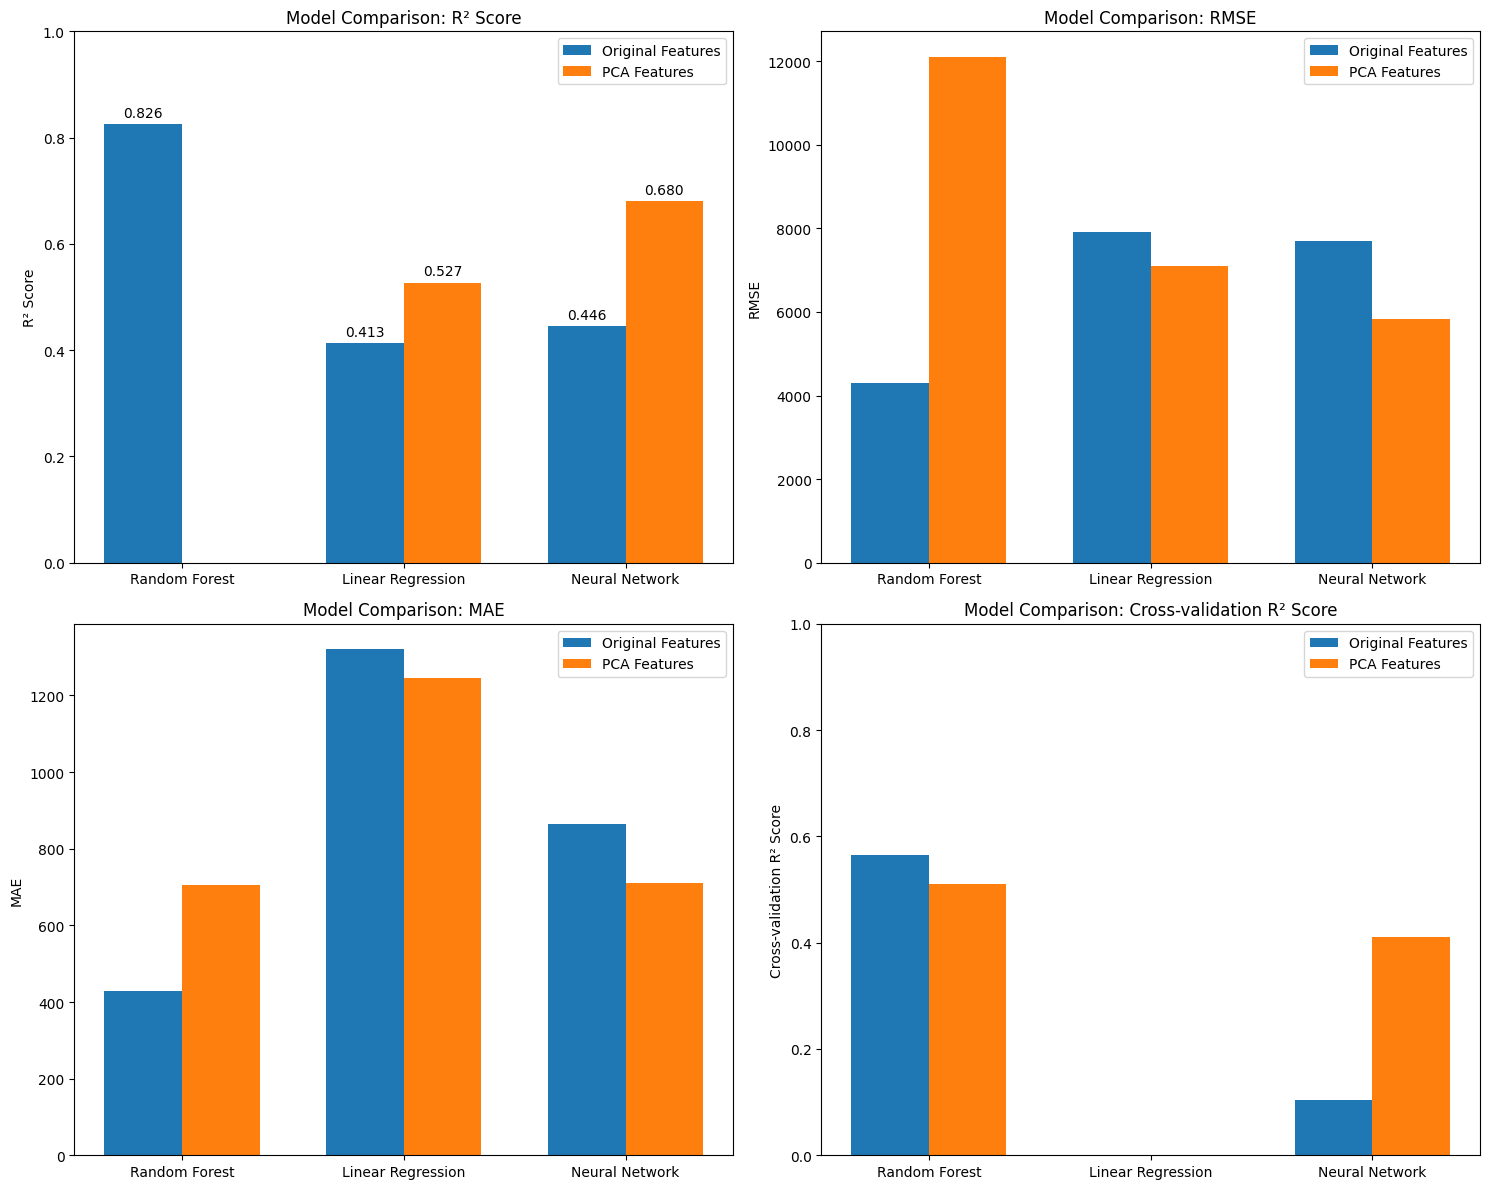

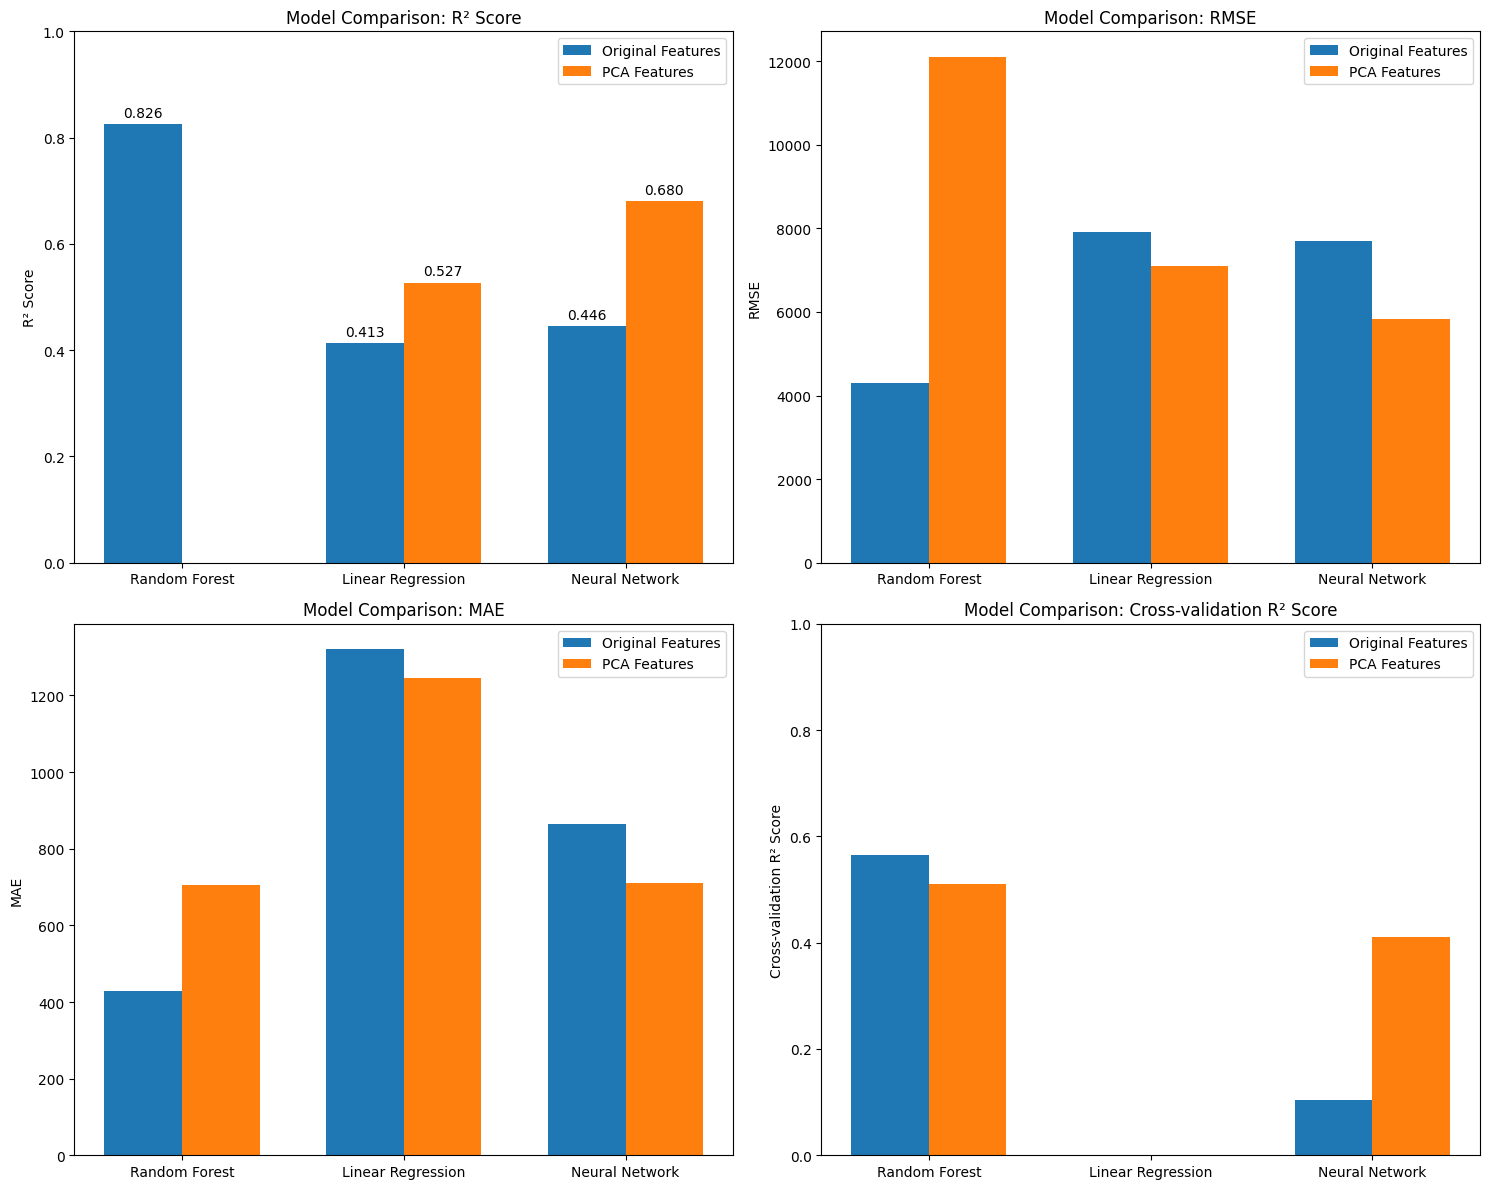

In [23]:
import matplotlib.pyplot as plt


def plot_model_comparison(original_results, pca_results):

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Prepare data
    models = ['Random Forest', 'Linear Regression', 'Neural Network']
    x = np.arange(len(models))
    width = 0.35

    # Get metrics
    original_r2 = [original_results[m]['r2'] for m in models]
    pca_r2 = [pca_results[m]['r2'] for m in models]

    original_rmse = [original_results[m]['rmse'] for m in models]
    pca_rmse = [pca_results[m]['rmse'] for m in models]

    original_mae = [original_results[m]['mae'] for m in models]
    pca_mae = [pca_results[m]['mae'] for m in models]

    original_cv = [original_results[m]['cv_r2_mean'] for m in models]
    pca_cv = [pca_results[m]['cv_r2_mean'] for m in models]

    # Plot R² Scores
    rects1 = ax1.bar(x - width/2, original_r2, width, label='Original Features')
    rects2 = ax1.bar(x + width/2, pca_r2, width, label='PCA Features')

    ax1.set_ylabel('R² Score')
    ax1.set_title('Model Comparison: R² Score')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.set_ylim(0, 1)

    # Add value labels
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', rotation=0)

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)

    # Plot RMSE
    ax2.bar(x - width/2, original_rmse, width, label='Original Features')
    ax2.bar(x + width/2, pca_rmse, width, label='PCA Features')

    ax2.set_ylabel('RMSE')
    ax2.set_title('Model Comparison: RMSE')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()

    # Plot MAE
    ax3.bar(x - width/2, original_mae, width, label='Original Features')
    ax3.bar(x + width/2, pca_mae, width, label='PCA Features')

    ax3.set_ylabel('MAE')
    ax3.set_title('Model Comparison: MAE')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models)
    ax3.legend()

    # Plot Cross-validation R² Scores
    ax4.bar(x - width/2, original_cv, width, label='Original Features')
    ax4.bar(x + width/2, pca_cv, width, label='PCA Features')

    ax4.set_ylabel('Cross-validation R² Score')
    ax4.set_title('Model Comparison: Cross-validation R² Score')
    ax4.set_xticks(x)
    ax4.set_xticklabels(models)
    ax4.legend()
    ax4.set_ylim(0, 1)

    plt.tight_layout()

    # Save the plot
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function
plot_model_comparison(original_results, pca_results)

# Create additional visualizations for feature importance (for Random Forest)
def plot_feature_importance(rf_pipeline, feature_names, n_features=20):
    plt.figure(figsize=(12, 6))

    if hasattr(rf_pipeline.named_steps['regressor'], 'feature_importances_'):
        importances = rf_pipeline.named_steps['regressor'].feature_importances_

        # Create DataFrame and sort
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=True)

        # Plot top n features
        plt.barh(feat_imp['Feature'].tail(n_features), feat_imp['Importance'].tail(n_features), color='skyblue')
        plt.title(f'Top {n_features} Most Important Features (Random Forest)')
        plt.xlabel('Importance')

        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
plot_model_comparison(original_results, pca_results)

Then, let us look at the importance of different features based on the random forest to see what may be the main factors concerning the success of games.

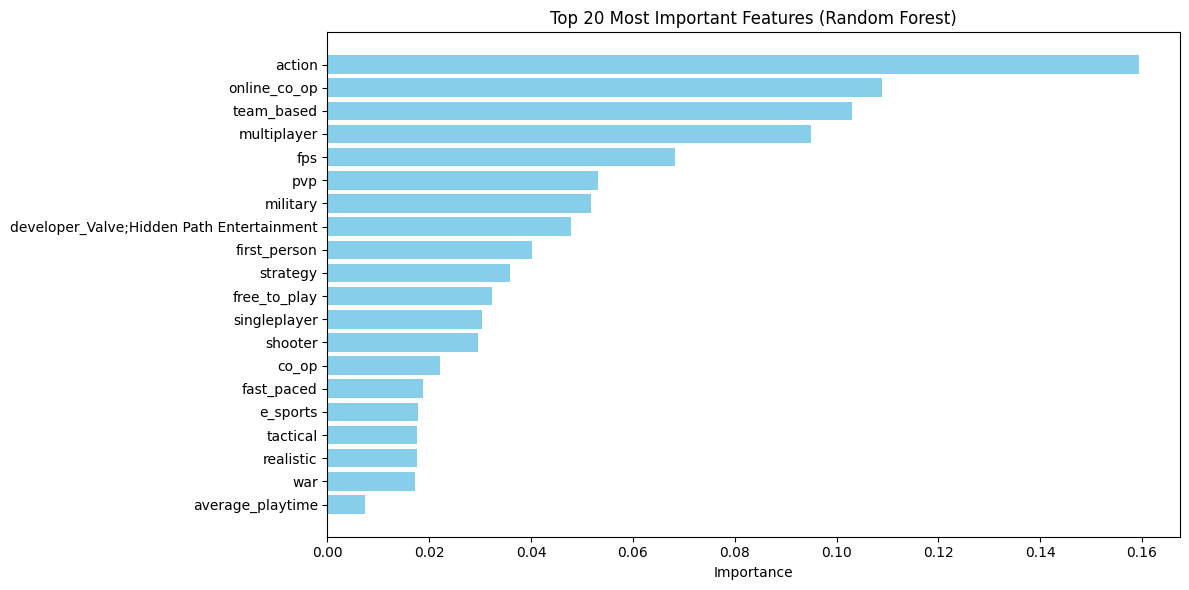

In [22]:
# Feature importance for Random Forest
rf_pipeline = original_models['Random Forest']

# Now plot feature importance
feature_names = (numeric_features_orig.tolist() +
                rf_pipeline.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features_orig).tolist())
plot_feature_importance(rf_pipeline, feature_names)

## Segmenting Analysis

If we look closely to the Supplementary file of the dataset. It contains tags from SteamSpy and the number of votes for each tag for each game. Higher numbers can be considered more strongly associated with that tag.

 Tags & Genre-Specific Analysis: Certain genres may respond differently to various factors (e.g., narrative depth for RPGs versus multiplayer dynamics for shooters). Understanding these nuances can aid developers in creating genre-appropriate gameplay and marketing strategies.

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 10 Tags by Correlation with Positive Ratings (Normalized):
team_based      0.179139
online_co_op    0.110073
e_sports        0.104223
multiplayer     0.092134
moddable        0.085315
pvp             0.084765
co_op           0.080846
competitive     0.079527
shooter         0.072342
fps             0.071057
dtype: float64


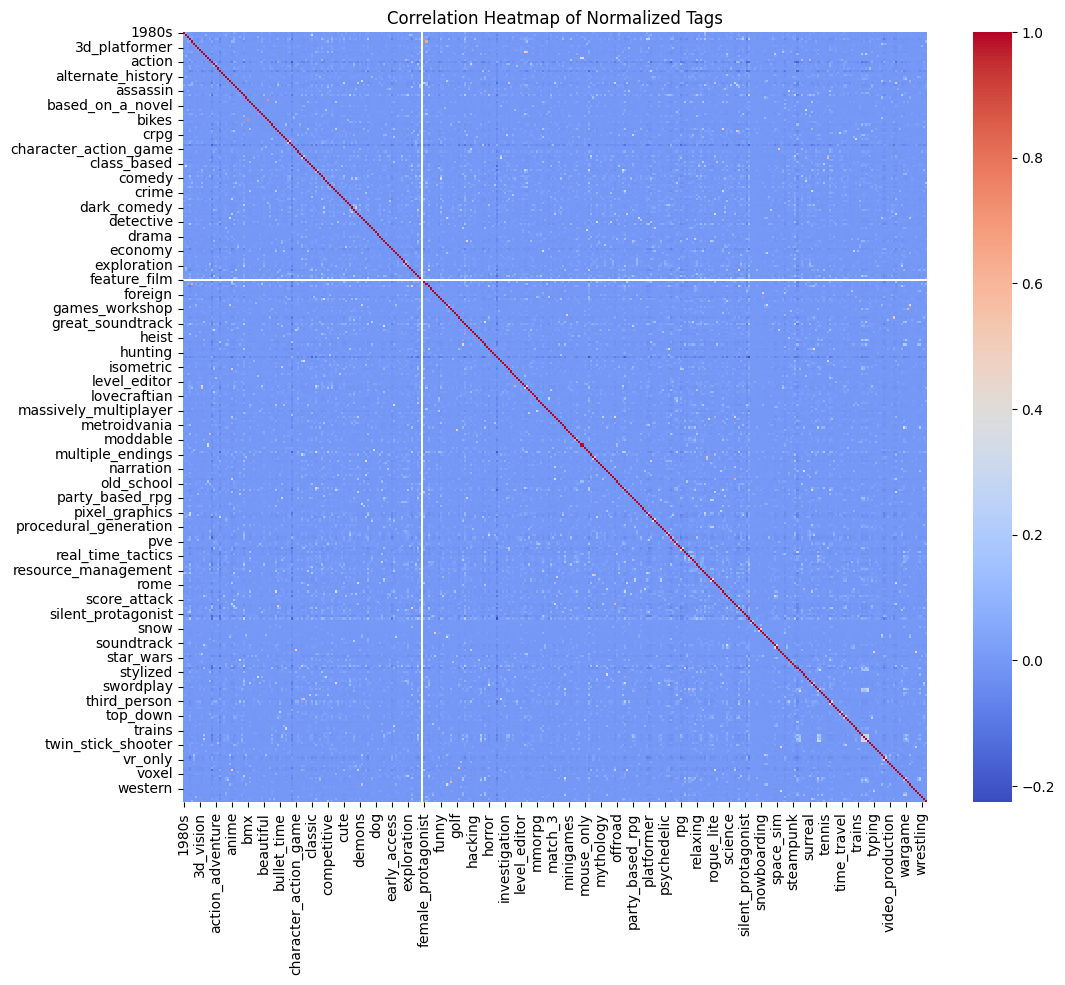

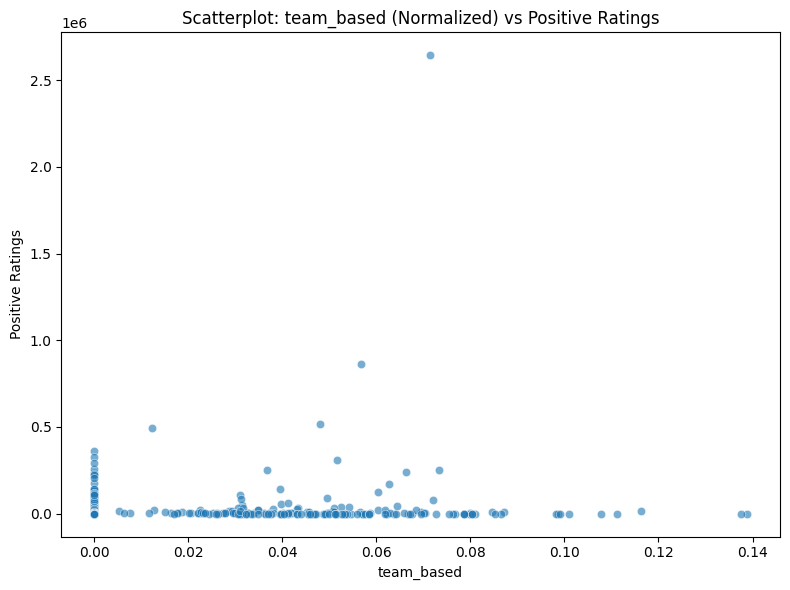

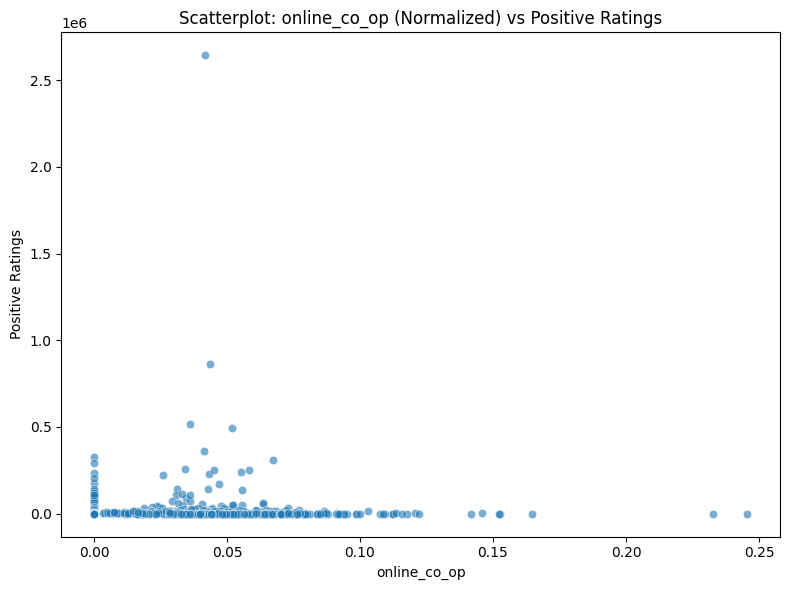

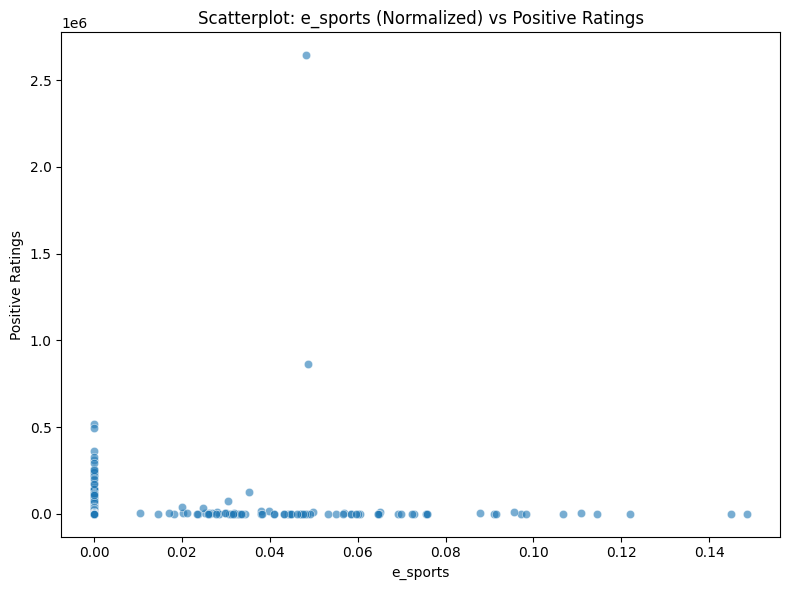

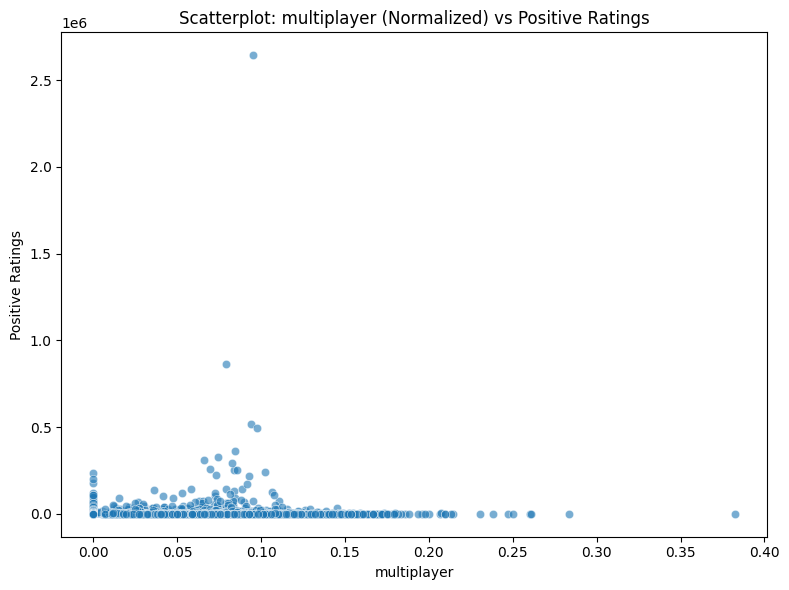

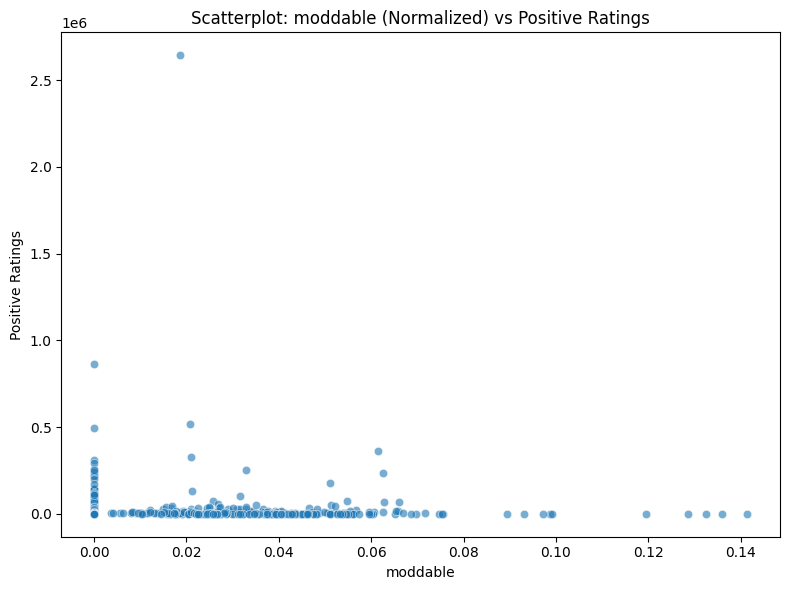

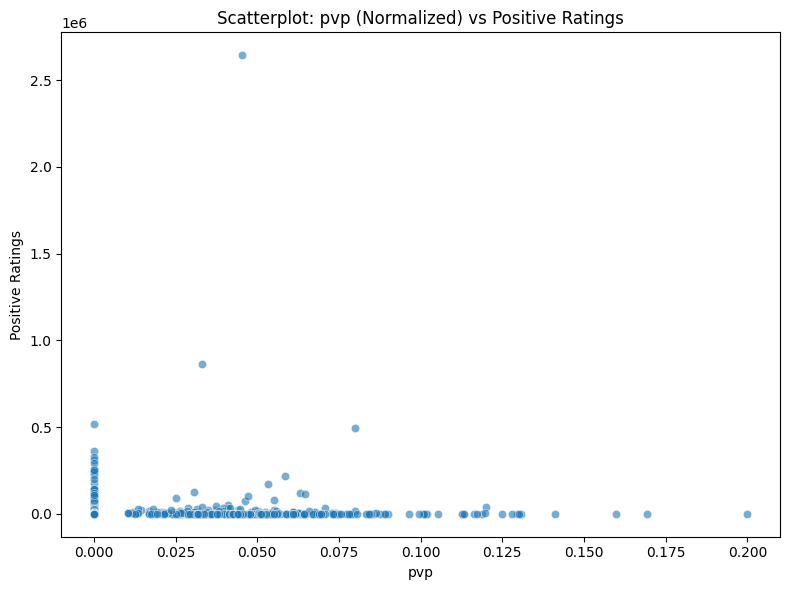

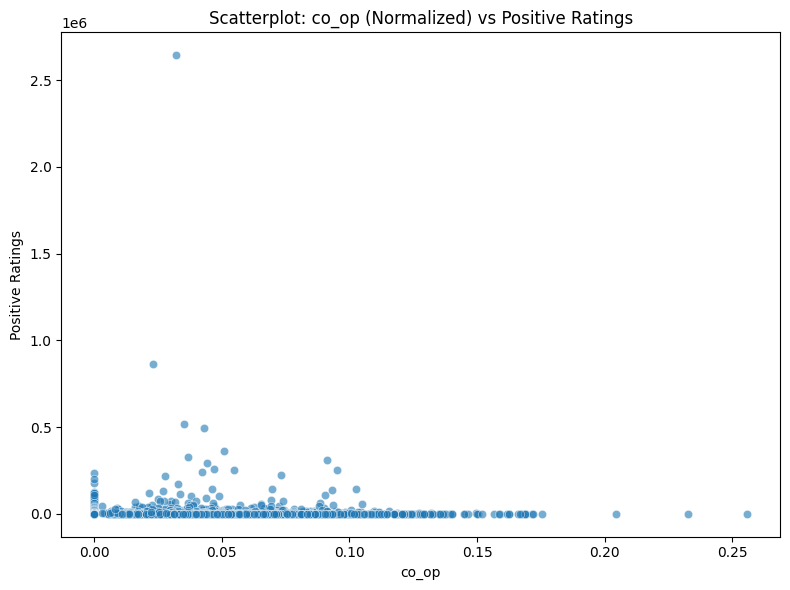

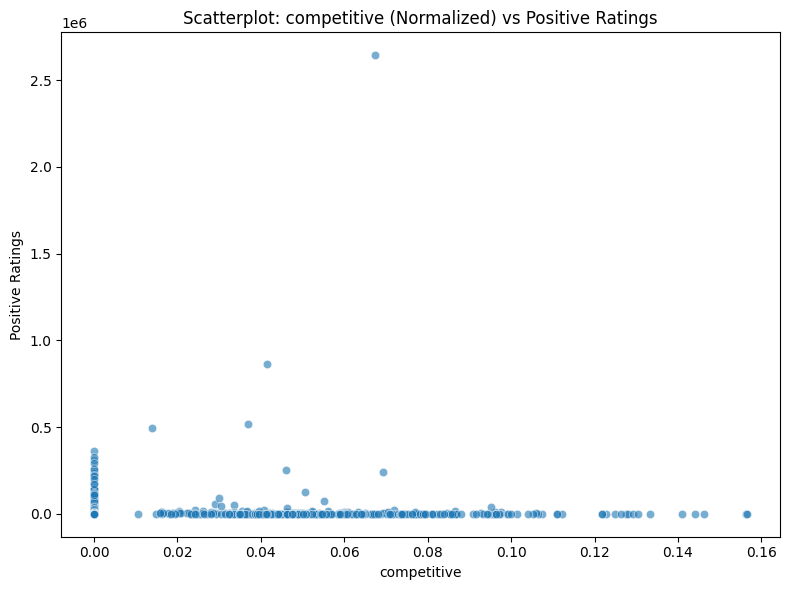

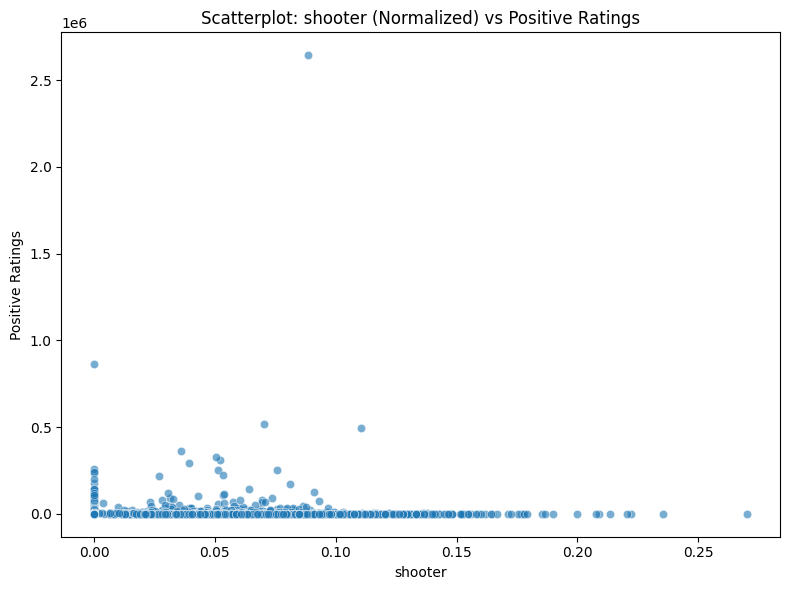

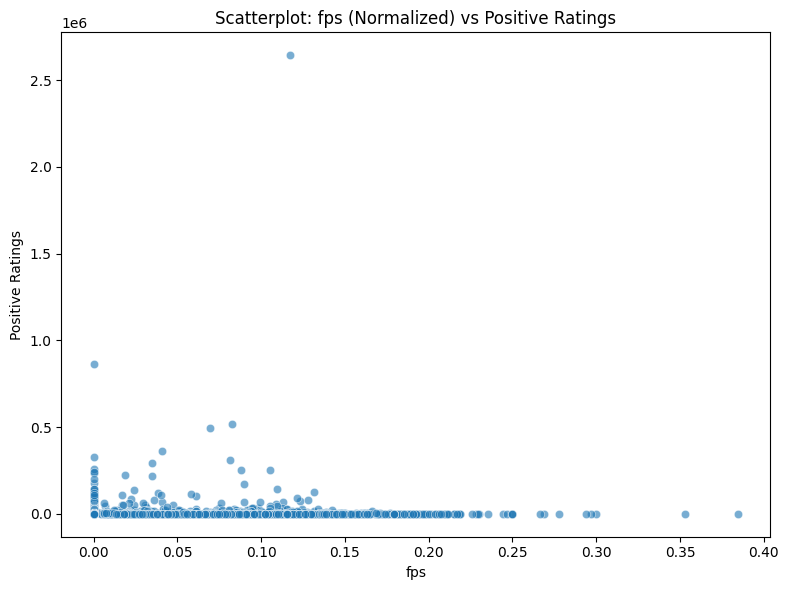

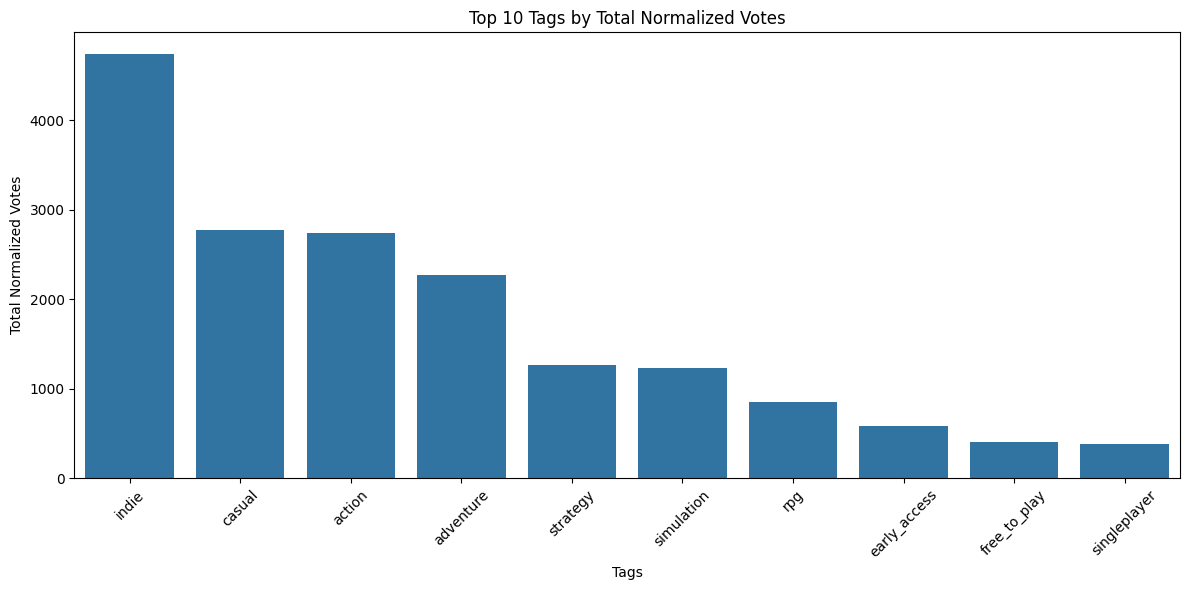

In [24]:
import seaborn as sns

tag_columns = [col for col in steamspy_tag_data.columns if col != 'appid']

# Normalize tag values by summing across all games
total_tag_votes = df[tag_columns].sum(axis=1)
normalized_tags = df[tag_columns].div(total_tag_votes, axis=0)

# Correlation between normalized tags and positive ratings
correlations = normalized_tags.corrwith(df['positive_ratings'])
correlations_sorted = correlations.sort_values(ascending=False)

# Display top 10 tags by correlation
print("Top 10 Tags by Correlation with Positive Ratings (Normalized):")
print(correlations_sorted.head(10))

# Visualization: Correlation heatmap of normalized tags
plt.figure(figsize=(12, 10))
sns.heatmap(normalized_tags.corr(), cmap='coolwarm', annot=False, cbar=True)
plt.title('Correlation Heatmap of Normalized Tags')
plt.show()

# Visualization: Top 10 normalized tags by correlation with scatterplots
for tag in correlations_sorted.head(10).index:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=normalized_tags[tag], y=df['positive_ratings'], alpha=0.6)
    plt.title(f'Scatterplot: {tag} (Normalized) vs Positive Ratings')
    plt.xlabel(tag)
    plt.ylabel('Positive Ratings')
    plt.tight_layout()
    plt.show()

# Visualization: Top 10 tags by total normalized votes
normalized_tag_sums = normalized_tags.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=normalized_tag_sums.head(10).index, y=normalized_tag_sums.head(10).values)
plt.title('Top 10 Tags by Total Normalized Votes')
plt.ylabel('Total Normalized Votes')
plt.xlabel('Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Using the proportion of votes for each tag as the feature values could be better than directly using one hot encoding since it captures the intensity of association between tags and games.

So we divide each tag's votes by the total votes for all tags for that game. This ensures that the feature values represent the relative importance of each tag for a game

In [35]:
# Final version using normalization and include all game types

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
df = pd.read_csv('merged_steam_data.csv', encoding='latin-1')

# Define game types
game_types = ['1980s', '1990s', '2.5d', '2d', '2d_fighter', '360_video', '3d', '3d_platformer',
              '3d_vision', '4_player_local', '4x', '6dof', 'atv', 'abstract', 'action', 'action_rpg',
              'action_adventure', 'addictive', 'adventure', 'agriculture', 'aliens', 'alternate_history',
              'america', 'animation_&_modeling', 'anime', 'arcade', 'arena_shooter', 'artificial_intelligence',
              'assassin', 'asynchronous_multiplayer', 'atmospheric', 'audio_production', 'bmx', 'base_building',
              'baseball', 'based_on_a_novel', 'basketball', 'batman', 'battle_royale', 'beat_em_up',
              'beautiful', 'benchmark', 'bikes', 'blood', 'board_game', 'bowling', 'building', 'bullet_hell',
              'bullet_time', 'crpg', 'capitalism', 'card_game', 'cartoon', 'cartoony', 'casual', 'cats',
              'character_action_game', 'character_customization', 'chess', 'choices_matter',
              'choose_your_own_adventure', 'cinematic', 'city_builder', 'class_based', 'classic', 'clicker',
              'co_op', 'co_op_campaign', 'cold_war', 'colorful', 'comedy', 'comic_book', 'competitive',
              'conspiracy', 'controller', 'conversation', 'crafting', 'crime', 'crowdfunded', 'cult_classic',
              'cute', 'cyberpunk', 'cycling', 'dark', 'dark_comedy', 'dark_fantasy', 'dark_humor',
              'dating_sim', 'demons', 'design_&_illustration', 'destruction', 'detective', 'difficult',
              'dinosaurs', 'diplomacy', 'documentary', 'dog', 'dragons', 'drama', 'driving',
              'dungeon_crawler', 'dungeons_&_dragons', 'dynamic_narration', 'dystopian_', 'early_access',
              'economy', 'education', 'emotional', 'epic', 'episodic', 'experience', 'experimental',
              'exploration', 'fmv', 'fps', 'faith', 'family_friendly', 'fantasy', 'fast_paced',
              'feature_film', 'female_protagonist', 'fighting', 'first_person', 'fishing', 'flight',
              'football', 'foreign', 'free_to_play', 'funny', 'futuristic', 'gambling', 'game_development',
              'gamemaker', 'games_workshop', 'gaming', 'god_game', 'golf', 'gore', 'gothic',
              'grand_strategy', 'great_soundtrack', 'grid_based_movement', 'gun_customization',
              'hack_and_slash', 'hacking', 'hand_drawn', 'hardware', 'heist', 'hex_grid', 'hidden_object',
              'historical', 'hockey', 'horror', 'horses', 'hunting', 'illuminati', 'indie',
              'intentionally_awkward_controls', 'interactive_fiction', 'inventory_management',
              'investigation', 'isometric', 'jrpg', 'jet', 'kickstarter', 'lego', 'lara_croft',
              'lemmings', 'level_editor', 'linear', 'local_co_op', 'local_multiplayer', 'logic', 'loot',
              'lore_rich', 'lovecraftian', 'mmorpg', 'moba', 'magic', 'management', 'mars', 'martial_arts',
              'massively_multiplayer', 'masterpiece', 'match_3', 'mature', 'mechs', 'medieval', 'memes',
              'metroidvania', 'military', 'mini_golf', 'minigames', 'minimalist', 'mining', 'mod',
              'moddable', 'modern', 'motocross', 'motorbike', 'mouse_only', 'movie', 'multiplayer',
              'multiple_endings', 'music', 'music_based_procedural_generation', 'mystery', 'mystery_dungeon',
              'mythology', 'nsfw', 'narration', 'naval', 'ninja', 'noir', 'nonlinear', 'nudity',
              'offroad', 'old_school', 'on_rails_shooter', 'online_co_op', 'open_world', 'otome',
              'parkour', 'parody_', 'party_based_rpg', 'perma_death', 'philisophical', 'photo_editing',
              'physics', 'pinball', 'pirates', 'pixel_graphics', 'platformer', 'point_&_click',
              'political', 'politics', 'pool', 'post_apocalyptic', 'procedural_generation', 'programming',
              'psychedelic', 'psychological', 'psychological_horror', 'puzzle', 'puzzle_platformer',
              'pve', 'pvp', 'quick_time_events', 'rpg', 'rpgmaker', 'rts', 'racing', 'real_time_tactics',
              'real_time', 'real_time_with_pause', 'realistic', 'relaxing', 'remake', 'replay_value',
              'resource_management', 'retro', 'rhythm', 'robots', 'rogue_like', 'rogue_lite', 'romance',
              'rome', 'runner', 'sailing', 'sandbox', 'satire', 'sci_fi', 'science', 'score_attack',
              'sequel', 'sexual_content', 'shoot_em_up', 'shooter', 'short', 'side_scroller',
              'silent_protagonist', 'simulation', 'singleplayer', 'skateboarding', 'skating', 'skiing',
              'sniper', 'snow', 'snowboarding', 'soccer', 'software', 'software_training', 'sokoban',
              'souls_like', 'soundtrack', 'space', 'space_sim', 'spectacle_fighter', 'spelling',
              'split_screen', 'sports', 'star_wars', 'stealth', 'steam_machine', 'steampunk',
              'story_rich', 'strategy', 'strategy_rpg', 'stylized', 'submarine', 'superhero',
              'supernatural', 'surreal', 'survival', 'survival_horror', 'swordplay', 'tactical',
              'tactical_rpg', 'tanks', 'team_based', 'tennis', 'text_based', 'third_person',
              'third_person_shooter', 'thriller', 'time_attack', 'time_management', 'time_manipulation',
              'time_travel', 'top_down', 'top_down_shooter', 'touch_friendly', 'tower_defense',
              'trackir', 'trading', 'trading_card_game', 'trains', 'transhumanism', 'turn_based',
              'turn_based_combat', 'turn_based_strategy', 'turn_based_tactics', 'tutorial',
              'twin_stick_shooter', 'typing', 'underground', 'underwater', 'unforgiving', 'utilities',
              'vr', 'vr_only', 'vampire', 'video_production', 'villain_protagonist', 'violent',
              'visual_novel', 'voice_control', 'voxel', 'walking_simulator', 'war', 'wargame',
              'warhammer_40k', 'web_publishing', 'werewolves', 'western', 'word_game', 'world_war_i',
              'world_war_ii', 'wrestling', 'zombies', 'e_sports']

def prepare_features(df, game_types):
    """
    Prepare features including normalized game type votes
    """
    # Basic feature processing
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month

    # Create price categories
    df['price_category'] = pd.qcut(df['price'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

    # Calculate rating metrics
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']

    # Normalize game type votes
    game_type_data = df[game_types].copy()
    total_votes = game_type_data.sum(axis=1)
    normalized_tags = game_type_data.div(total_votes, axis=0).fillna(0)

    # Add vote total as a feature
    normalized_tags['total_tag_votes'] = total_votes

    # Basic features
    basic_features = [
        'price', 'release_year', 'release_month', 'required_age',
        'achievements', 'average_playtime', 'median_playtime',
        'rating_ratio', 'total_ratings'
    ]

    # Categorical features
    categorical_features = ['developer', 'publisher', 'price_category']

    # Combine all features
    feature_df = pd.concat([
        df[basic_features + categorical_features],
        normalized_tags
    ], axis=1)

    return feature_df

# Prepare features
X = prepare_features(df, game_types)
y = df['positive_ratings']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Add the cross-validation evaluation function
def evaluate_model(model, X, y, cv=5, sample_size=5000):
    """
    Evaluate model using cross-validation once and calculate all metrics
    """
    if len(X) > sample_size:
        sample_idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X.iloc[sample_idx]
        y_sample = y.iloc[sample_idx]
    else:
        X_sample = X
        y_sample = y

    from sklearn.model_selection import cross_validate

    # Run cross-validation once with multiple metrics
    scores = cross_validate(model, X_sample, y_sample,
                          cv=cv,
                          scoring={
                              'r2': 'r2',
                              'mse': 'neg_mean_squared_error',
                              'mae': 'neg_mean_absolute_error'
                          })

    return {
        'cv_r2_mean': scores['test_r2'].mean(),
        'cv_r2_std': scores['test_r2'].std(),
        'cv_rmse_mean': np.sqrt(-scores['test_mse'].mean()),
        'cv_rmse_std': np.sqrt(-scores['test_mse'].std()),
        'cv_mae_mean': -scores['test_mae'].mean(),
        'cv_mae_std': -scores['test_mae'].std()
    }
# Create and evaluate Random Forest model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        random_state=42
    ))
])

# Perform cross-validation
print("Performing cross-validation...")
cv_results = evaluate_model(rf_pipeline, X, y)

# Train final model
print("Training final model...")
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

# Calculate metrics
test_r2 = r2_score(y_test, rf_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
test_mae = mean_absolute_error(y_test, rf_pred)

# Print results
print("\nRandom Forest Model Performance:")
print("-" * 50)
print("Cross-validation Results:")
print(f"CV R² Score: {cv_results['cv_r2_mean']:.4f} (±{cv_results['cv_r2_std']:.4f})")
print(f"CV RMSE: {cv_results['cv_rmse_mean']:.2f} (±{cv_results['cv_rmse_std']:.2f})")
print(f"CV MAE: {cv_results['cv_mae_mean']:.2f} (±{cv_results['cv_mae_std']:.2f})")
print("\nTest Set Results:")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

# Feature importance analysis (your existing code)
feature_names = (numeric_features.tolist() +
                rf_pipeline.named_steps['preprocessor']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features).tolist())

importances = rf_pipeline.named_steps['regressor'].feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feat_imp.head(20))

Performing cross-validation...
Training final model...

Random Forest Model Performance:
--------------------------------------------------
Cross-validation Results:
CV R² Score: 0.8152 (±0.2831)
CV RMSE: 7857.78 (±13976.21)
CV MAE: 257.50 (±464.70)

Test Set Results:
Test R² Score: 0.8070
Test RMSE: 4539.76
Test MAE: 123.02

Top 20 Most Important Features:
                                         Feature  Importance
6                                  total_ratings    0.671879
13024  developer_Valve;Hidden Path Entertainment    0.187897
378                              total_tag_votes    0.118033
257                                          rts    0.005932
3                               average_playtime    0.005480
339                                tower_defense    0.002842
134                                 free_to_play    0.002313
2                                   achievements    0.002068
59                                       cartoon    0.001396
5                             

## Longitudinal Studies
Trend Analysis Over Time: Conduct longitudinal studies to analyze how player preferences evolve over time or how the gaming landscape shifts (e.g., in response to technological advancements or changing social norms). This can help developers anticipate future trends and adjust their strategies accordingly.